In [ ]:
import numpy as np
import pandas as pd
########################################################################
########################################################################
########################################################################
def random_Transition_matrix(m):#, recursive=True
    """
    Generates a random NumPy matrix of size m x m with nonnegative elements.
    Args:
    m (int): The number of rows, columns in the matrix.
    Returns:
    numpy.ndarray: A random NumPy matrix of size m x m with nonnegative elements, where sum of element in each row is one.
    """
  # Use np.random.rand to generate random values between 0 (inclusive) and 1 (exclusive)
    # if (recursive==False):

    matrix = np.random.rand(m, m) # uniform distribution
    # want different distribution per station, distribution variable per station (eg. normal, beta)
    matrix= (matrix/matrix.sum(axis=0)).T
  # Convert the random values to integers to ensure nonnegativity
#   matrix = matrix.astype(np.float)

    return matrix
########################################################################
########################################################################

########################################################################
########################################################################
########################################################################
def Transition_time(distributions, N):

    Transition_time = np.zeros(N)

    # Fill the array with values from different distributions
    for i in range(N):
        dist_name, params = distributions[i]
        Transition_time[i] = getattr(np.random, dist_name)(**params)

    return Transition_time.astype(int)
########################################################################
########################################################################
########################################################################

In [ ]:
def simulate(capacity):
  N = 4 # number of stations
  CarArrivalRatePerUnitTime = 65/(3*60*60) # number of arrivals per iteration (# cars arriving per second)
  df_cars = pd.DataFrame(data=np.zeros(1), columns=["#NotProcessedPeopleInCar"])
  ProcessRate = 100 # max number of people can enter to stations line in each second
  MaxLength = 100
  ParkingCapacity = capacity

  # parkingcapacities = list(range(5, 66, 5))
  NumberOfCarsInParkingLine = 0
  EntranceLine_list = []
  ExitLine_list = []
  EntranceLineLength_list = [0]
  OccupiedParking_list = [0]
  ParkingWaitingLineLength_list = [0]
  FullyProcessedPeople = np.zeros(N+1)

  # data = [[[],]*N]
  data =[[[],]*1]


  StationsNameList = [(i) for i in range(N)]
  df_StationLines = pd.DataFrame(data, index=StationsNameList, columns=["CurrentLine"])
  df_StationLines.index.name = "StationNumber"

  df_StationWaitingTime = pd.DataFrame(data, index=StationsNameList, columns=["WaitingTime"])
  df_StationWaitingTime.index.name = "StationNumber"

  df_StationLineLength = pd.DataFrame(0, index=StationsNameList, columns=["LineLength"])
  df_StationLineLength.index.name = "StationNumber"

  df_StationServers = pd.DataFrame(np.array([7,3,3,3]).astype(int), index=StationsNameList, columns=["NumberOfServers"])
  df_StationServers.index.name="StationNumber"

  df_StationLineLength_History = df_StationLineLength.copy()
  df_StationLineLength_History.columns = ["0"]

  Init_state =  np.zeros(N)
  Init_state =  np.ones([N]) #random_Transition_matrix(N)[0,:]
  new_state_prob = Init_state
  Transition_matrix = np.ones([N,N])/N # random_Transition_matrix(N)
  distributions = [
          #('normal', {'loc': 20, 'scale': 10}),  # Normal distribution for first station
          #('normal', {'loc': 20, 'scale': 10}),  # Normal distribution for second station
          #('normal', {'loc': 20, 'scale': 10}),  # Normal distribution for third station
          #('uniform', {'low': 10, 'high': 100}),  # Uniform distribution for fourth station
          #('exponential', {'scale': 20}),  # Exponential distribution for fifth station
          #('uniform', {'low': 400, 'high': 800}),  # Uniform distribution for 1st station,
          #('uniform', {'low': 200, 'high': 400}),  # Uniform distribution for 2nd station
          #('uniform', {'low': 200, 'high': 400}),  # Uniform distribution for 3rd station
          #('uniform', {'low': 200, 'high': 400}),  # Uniform distribution for 4th station
          ('exponential', {'scale': 600}),  # Uniform distribution for 1st station, clothing
          ('exponential', {'scale': 300}),  # Uniform distribution for 2nd station
          ('exponential', {'scale': 300}),  # Uniform distribution for 3rd station
          ('exponential', {'scale': 300}),  # Uniform distribution for 4th station
      ]
  #generating service time

  CarID = 0
  for CurrentTime in range(int(3.5*60*60)): # Studied period of time
  ########################################################################
  ########        Process How Cars Enter the Parking         #############
  ########################################################################
    if (CurrentTime<3*60*60):#3*60*60 # if Active hours
      CurrentCarArrivalRate = np.random.poisson(CarArrivalRatePerUnitTime, 1)[0] # number of car arrival rate
      NumberOfCarsInParkingLine += CurrentCarArrivalRate
      ParkingAvailbaleCapacity = ParkingCapacity-sum(df_cars.loc[:,"#NotProcessedPeopleInCar"]>0)

      if(ParkingAvailbaleCapacity<=0): # change it to when the parking has free spot
        NumberOfNewCarsEnteringTheParking = 0 #int(np.random.rand()*ArrivalRate)

      else:
        NumberOfNewCarsEnteringTheParking = min(ParkingAvailbaleCapacity, NumberOfCarsInParkingLine)
        NumberOfCarsInParkingLine -= NumberOfNewCarsEnteringTheParking



          # FullyProcessedPeople[0]=FullyProcessedPeople[0]+(CurrentCarArrivalRate-CurrentFeasibleCarArrivalRate) # it's not actually exactly fully processed,
                                                                                                # but all who left beceause they had no available choice at their last step
                                                                                                # [0] counts number of cars that left due to parking capacity constraints

      for NewCar in range(NumberOfNewCarsEnteringTheParking):
          NumberOfPeopleInCar=np.random.randint(1,3)
          df_cars.loc[CarID,"#NotProcessedPeopleInCar"] = NumberOfPeopleInCar
          for i in range(NumberOfPeopleInCar):
            NewCarPeople = np.zeros([2,N+1])
            NewCarPeople[1,-1] = CarID
            NewCarPeople[0,-1] = 4*60 # assume each person spends 4 min. at parking
            NewCarPeople[0,:-1] = Transition_time(distributions, N)
            # we randomly generate the amount of time each person spends in each station server
            # time spent at each station is btw. 30 <= t <= 240 secs

            if (np.random.rand()>0.25): NewCarPeople[0,0]=0 # only %25 of shoppers complete clothing (assume station 0 is for clothing)
            EntranceLine_list = [NewCarPeople] + EntranceLine_list
            # entranceline_list is a list of arrays, where each array contains the data of the time a single person spends at each station
          CarID+=1
        # print(NewCarPeople)

          # EntranceLine_list=[np.zeros([N])]*CurrentArrivalRate+EntranceLine_list # modify it that some of them will leave ...
    else: EntranceLine_list = EntranceLine_list # modify it that some of them will leave ...

  ########################################################################
  ########      Process how people enter the stations' lines   ############
  ########################################################################
      # How many free spots are available in all stations, so we can atmost let that number in
    TotalFreeAvailableSpotInStations = MaxLength*N-df_StationLineLength.iloc[:, 0].sum()

    if(TotalFreeAvailableSpotInStations>0):
        ProcessNowRate = min(ProcessRate, len(EntranceLine_list), TotalFreeAvailableSpotInStations) # number of people enter to the end of stations' lines
        for _ in range(ProcessNowRate):
          person_history = EntranceLine_list[-1].copy()
          del EntranceLine_list[-1]# remove this person from list of people in the entarnce line

          Adjusted_Init_state = np.zeros(N)
          FreeStationIndex = list(np.argwhere(df_StationLineLength<MaxLength)[:,0]) # find index of free stations
          FullStationIndex = list(np.argwhere(df_StationLineLength>=MaxLength)[:,0]) # find index of full stations
          FeasibleStationIndex = list (set(FreeStationIndex).intersection(set(list(np.argwhere(person_history[0,:-1]>0)[:,0]))))
          # feasible station: A station where the person's transition matrix indicates they spend >= 0 time at that station
          InFeasibleStationIndex = list (set(FullStationIndex).union(set(list(np.argwhere(person_history[0,:-1]==0)[:,0]))))

          if(len(FeasibleStationIndex)>0):
            # EmptyStationIndex = list((df_StationLineLength < 20).values)
            Adjusted_Init_state[FeasibleStationIndex] = (0.001+Init_state[FeasibleStationIndex])/(Init_state[FeasibleStationIndex].sum()+0.001*len(FeasibleStationIndex))
            #Normalizes the probabilities by dividing each by the total sum of feasible station probabilities. The small value (0.001) is also added to the denominator to prevent division by zero.
            #Result: This line adjusts the initial state probabilities (Init_state) for stations that are feasible, ensuring that the probabilities sum to 1
            Adjusted_Init_state[InFeasibleStationIndex] = 0
            #Set the probability to zero for infeasible stations

            station = np.random.choice(StationsNameList, size=1, p=list(Adjusted_Init_state))[0]
            # randomly chooses one value from StationsNameList given the adjusted probabilities

            # person_history[0,station]+=1
            #add the person to the chosen station's line & update the length of the line
            df_StationLines.iloc[station, 0] = [person_history] + df_StationLines.iloc[station, 0]
            df_StationLineLength.iloc[station, 0]=len(df_StationLines.iloc[station, 0]) #df_StationLineLength.iloc[station, 0]+1

    for station in StationsNameList: df_StationLineLength.iloc[station, 0]=len(df_StationLines.iloc[station, 0])
  ########################################################################
  ########      Process how they transit and exit stations' lines   ############
  ########################################################################
    new_state_prob = np.dot(new_state_prob, Transition_matrix)
    NonEmptyStationIndex = list(np.argwhere(df_StationLineLength>0)[:,0])
      #finds stations that have people in line

      # print("777777", df_StationLineLength, NonEmptyStationIndex)
      # print('***', list(df_StationLineLength.iloc[NonEmptyStationIndex].index))

    for station in NonEmptyStationIndex: #list(df_StationLineLength.iloc[NonEmptyStationIndex].index):
      PeopleInStationLineOutOfServer = (df_StationLineLength.iloc[station, 0]-min(df_StationLineLength.iloc[station, 0], df_StationServers.iloc[station, 0]))
      # number of people not being served
      for k in range(PeopleInStationLineOutOfServer):
        #updating the time a person has spent waiting in line to be served (+ 1 sec)
        df_StationLines.iloc[station, 0][k][1,station]+=1 # add how many seconds this person is staying in this station's line
      # people currently being served
      PeopleInStationServer = min(df_StationLineLength.iloc[station, 0], df_StationServers.iloc[station, 0])
      ServedPeople=0
        #initializing a counter for the # of people who have been FULLY served
      for k in range(PeopleInStationServer): # go through people who are currently being served

        # print(StaionBusyServer, k)

        # print(df_StationLines.loc[station, ["CurrentLine"]])
        #increment time the person has spent waiting to be served/being served
        #and decrement their remaining time to be served at the station
        df_StationLines.iloc[station, 0][-k+ServedPeople-1][1,station]+=1 # add to see how many seconds this person is staying in this station's line
        df_StationLines.iloc[station, 0][-k+ServedPeople-1][0,station]-=1 # deduct to see how many seconds this person left to be served by this station's server
        if(df_StationLines.iloc[station, 0][-k+ServedPeople-1][0,station]==0): #if service is complete (wait time == 0)
          #collecting their data and recording how long the person waited, then remove them from the station line
          person_history = df_StationLines.iloc[station, 0][-k+ServedPeople-1].copy()
          df_StationWaitingTime.iloc[station, 0]= [person_history[1,station]] + df_StationWaitingTime.iloc[station, 0] # records how long the person waited at this station
          del df_StationLines.iloc[station, 0][-k+ServedPeople-1] # removes the person from the station's line
          #increment the count of served people
          ServedPeople +=1
          #update line length
          df_StationLineLength.iloc[station, 0]=len(df_StationLines.iloc[station, 0]) #df_StationLineLength.iloc[station, 0]-1

    # Now the first person in this line person goes to another station if she hasn't been to at least one
      # finds stations with open space that the person hasn't visited
          OpenStationIndex = list (set(list(np.argwhere(df_StationLineLength<MaxLength)[:,0])).intersection(set(list(np.argwhere(person_history[0,:-1]>0)[:,0]))))
          # print("888888   ", OpenStationIndex, station)
          if(len(OpenStationIndex)>0): # check if there are open stations
              Current_state_prob = Transition_matrix[station, :].copy() #np.zeros(N) # list(set(x) - set(y))
              # OpenStationIndex = list (set(list(np.argwhere(df_StationLineLength<MaxLength)[:,0])).intersection(set(list(np.argwhere(person_history>0)[:,0]))))
              BlockedStationIndex = list (set(list(np.argwhere(df_StationLineLength>=MaxLength)[:,0])).union(set(list(np.argwhere(person_history[0,:-1]==0)[:,0]))))
              #finds stations that are blocked (either full or previously visited)
              Current_state_prob[:]=(0.001+Current_state_prob[:])/(np.sum(Current_state_prob[:])+0.001*N)
              #normalizes the current state probabilities:
              # adds a small value to each to avoid a probability of 0 and makes all probabilities sum to 1


              Adjusted_current_state_prob=np.zeros(N)
              Adjusted_current_state_prob[OpenStationIndex] = Current_state_prob[OpenStationIndex]/Current_state_prob[OpenStationIndex].sum()
              #adjusting the state probabilities for open stations
              Adjusted_current_state_prob[BlockedStationIndex]=0
              #if blocked, the new adjusted state probability is set to 0
              new_station = np.random.choice(StationsNameList, size=1, p=list(Adjusted_current_state_prob))[0]
              #randomly selects a new stations based on the adjusted probabilities
              # print("\n **********   ",x,  new_station,(person_history), Adjusted_current_state_prob)
              df_StationLines.iloc[new_station, 0] = [person_history] + df_StationLines.iloc[new_station, 0]
              #move person to newly selected station
              df_StationLineLength.iloc[new_station, 0] = len(df_StationLines.iloc[new_station, 0]) #df_StationLineLength.iloc[new_station, 0]+1
              #update line length


          else: #if there are no more available stations, the person exits the code and is added to the exit list
            # print(person_history)
            ExitLine_list = [person_history] + ExitLine_list
            FullyProcessedPeople[int(sum(person_history[1,:-1]>0))] = FullyProcessedPeople[int(sum(person_history[1,:-1]>0))]+1
            # it's not actually exactly fully processed, but all who left beceause they had no available choice at their last step
            # PersonCarID=person_history[1,-1]

  ########################################################################
  ########        simulate waiting time for people to get to the car         ############
  ########################################################################

    ServedPeople_=0
    CurrentExitLine_length=len(ExitLine_list)
    for kkk in range(CurrentExitLine_length):
      ExitLine_list[ServedPeople_-kkk-1][0,-1]=ExitLine_list[ServedPeople_-kkk-1][0,-1]-1
      # print(ExitLine_list[ServedPeople_-kkk-1])
      if(ExitLine_list[ServedPeople_-kkk-1][0,-1]==0):
        PersonCarID=ExitLine_list[ServedPeople_-kkk-1][1,-1]
        # print(PersonCarID, "***", ExitLine_list[ServedPeople_-kkk-1], "\n\n")
        del ExitLine_list[ServedPeople_-kkk-1]
        ServedPeople_+=1
        df_cars.loc[PersonCarID,"#NotProcessedPeopleInCar"] = df_cars.loc[PersonCarID,"#NotProcessedPeopleInCar"]-1


        # state=np.dot(state,P)
        # print(state)
        # stateHist=np.append(stateHist,state,axis=0)
        # dfDistrHist = pd.DataFrame(stateHist)
        # dfDistrHist.plot()
        # plt.show()

    # print(df_StationLineLength)

    df_StationLineLength.columns=[str(CurrentTime+1)]
    df_StationLineLength_History=pd.concat([df_StationLineLength_History, df_StationLineLength], axis=1)
    EntranceLineLength_list=EntranceLineLength_list+[len(EntranceLine_list)]
    OccupiedParking_list=OccupiedParking_list+[sum(df_cars.loc[:,"#NotProcessedPeopleInCar"]>0)]
    ParkingWaitingLineLength_list=ParkingWaitingLineLength_list + [NumberOfCarsInParkingLine]

  AverageWaitingTime=[]
  for station in StationsNameList:
    AverageWaitingTime+= [np.mean(df_StationWaitingTime.iloc[station,0])]
  avg_wait_all_stations = (sum(AverageWaitingTime) + 240) / (len(AverageWaitingTime) + 1)

  return df_StationLineLength_History, EntranceLineLength_list, OccupiedParking_list, ParkingWaitingLineLength_list, FullyProcessedPeople, avg_wait_all_stations, df_StationWaitingTime

In [ ]:
df_StationLineLength_History, EntranceLineLength_list, OccupiedParking_list, ParkingWaitingLineLength_list, FullyProcessedPeople, avg_wait_all_stations, df_StationWaitingTime = simulate(65)




In [ ]:
print(avg_wait_all_stations)

553.5265632801716


<Axes: >

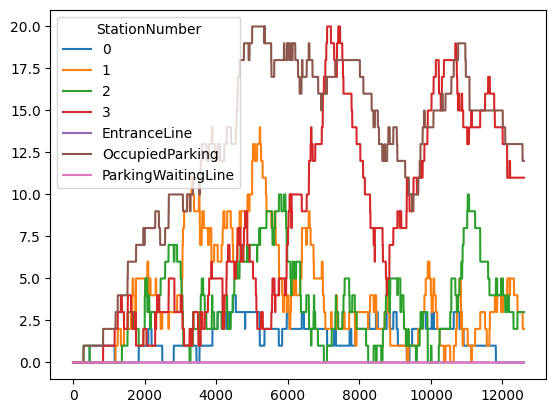

In [ ]:
# print(OccupiedParking_list)
# print(sum(OccupiedParking_list)/len(OccupiedParking_list))
# print(sum(ParkingWaitingLineLength_list) / len(ParkingWaitingLineLength_list))

df_StationLineLength_History.loc["EntranceLine"]=EntranceLineLength_list
df_StationLineLength_History.loc["OccupiedParking"] =OccupiedParking_list
df_StationLineLength_History.loc["ParkingWaitingLine"] =ParkingWaitingLineLength_list

# df_StationLineLength_History.iloc[:-2,:].T.plot()
df_StationLineLength_History.iloc[:,:].T.plot()

# print(FullyProcessedPeople)

In [ ]:
def simulate_parking():
  numsimulations = 5
  average_occupied_capacity = []
  average_waiting_time = []
  average_all_stations = []
  for capacity in range(5,31,5):
    occupied_i = []
    parkingwaiting_i = []
    all_stations_i = []
    for i in range(numsimulations):
      df_StationLineLength_History, EntranceLineLength_list, OccupiedParking_list, ParkingWaitingLineLength_list, FullyProcessedPeople, avg_all_stations, _ = simulate(capacity)
      avg_occupied = sum(OccupiedParking_list) / len(OccupiedParking_list)
      avg_parkingwaiting = sum(ParkingWaitingLineLength_list) / len(ParkingWaitingLineLength_list)
      occupied_i.append(avg_occupied)
      parkingwaiting_i.append(avg_parkingwaiting)
      all_stations_i.append(avg_all_stations)

    average_occupied_capacity.append(sum(occupied_i) / len(occupied_i))
    average_waiting_time.append(sum(parkingwaiting_i) / len(parkingwaiting_i))
    average_all_stations.append(sum(all_stations_i) / len(all_stations_i))

    print("average_occupied_capacity_parking: " + str(average_occupied_capacity))
    print("average_waiting_time_parking: " + str(average_waiting_time))
    print("average_wait_time_total: " + str(average_all_stations))

  return average_occupied_capacity, average_waiting_time, average_all_stations

In [ ]:
avg_occupied_capacity_parking, avg_waiting_time_parking, avg_wait_all_stations = simulate_parking() # ~takes 25 minutes

average_occupied_capacity_parking: [4.44518688992937]
average_waiting_time_parking: [16.97557336719308]
average_wait_time_total: [356.26919407766127]
average_occupied_capacity_parking: [4.44518688992937, 8.524625029759545]
average_waiting_time_parking: [16.97557336719308, 5.128910403936194]
average_wait_time_total: [356.26919407766127, 455.04525587791215]
average_occupied_capacity_parking: [4.44518688992937, 8.524625029759545, 10.166399492103801]
average_waiting_time_parking: [16.97557336719308, 5.128910403936194, 2.6794063963177526]
average_wait_time_total: [356.26919407766127, 455.04525587791215, 488.51193789345615]
average_occupied_capacity_parking: [4.44518688992937, 8.524625029759545, 10.166399492103801, 12.817919212760893]
average_waiting_time_parking: [16.97557336719308, 5.128910403936194, 2.6794063963177526, 1.0118085866201096]
average_wait_time_total: [356.26919407766127, 455.04525587791215, 488.51193789345615, 546.1392631575824]
average_occupied_capacity_parking: [4.445186889

In [ ]:
avg_occupied_percentages_parking = [round((value / ((index + 1) * 5)) * 100, 2) for index, value in enumerate(avg_occupied_capacity_parking)]
avg_occupied_percentages_parking

[88.9, 85.25, 67.78, 64.09, 55.98, 50.76]

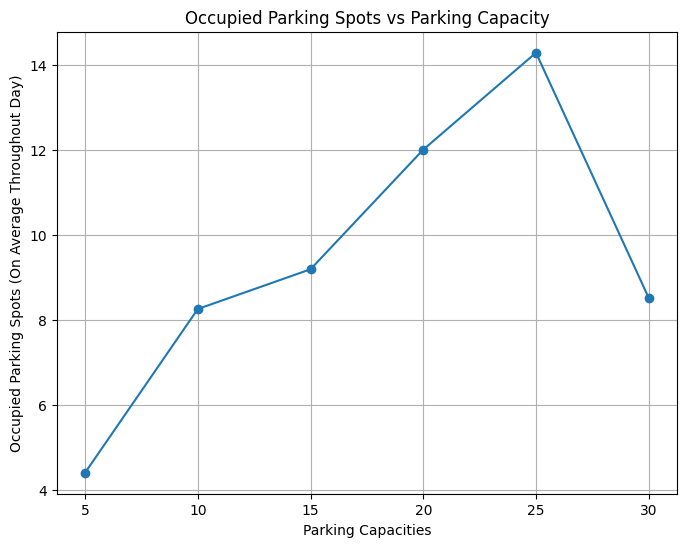

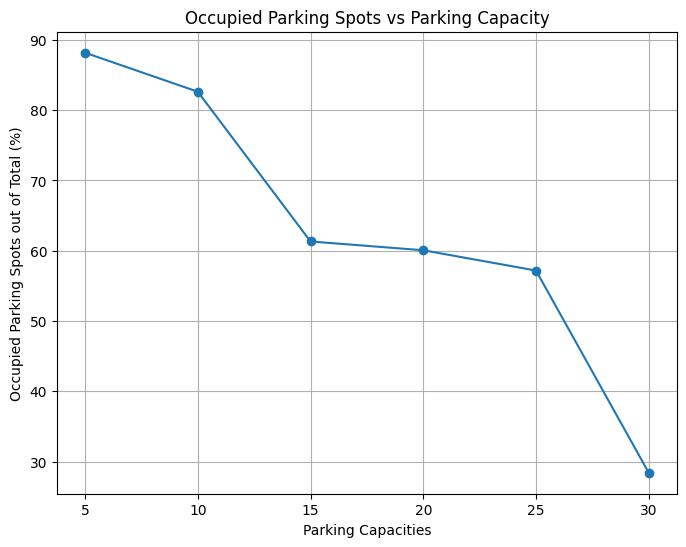

In [ ]:
import matplotlib.pyplot as plt

capacities = list(range(5, 31, 5))

plt.figure(figsize=(8, 6))
plt.plot(capacities, avg_occupied_capacity_parking, marker='o')
plt.xlabel("Parking Capacities")
plt.ylabel("Occupied Parking Spots (On Average Throughout Day)")
plt.title("Occupied Parking Spots vs Parking Capacity")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(capacities, avg_occupied_percentages_parking, marker='o')
plt.xlabel("Parking Capacities")
plt.ylabel("Occupied Parking Spots out of Total (%)")
plt.title("Occupied Parking Spots vs Parking Capacity")
plt.grid(True)
plt.show()


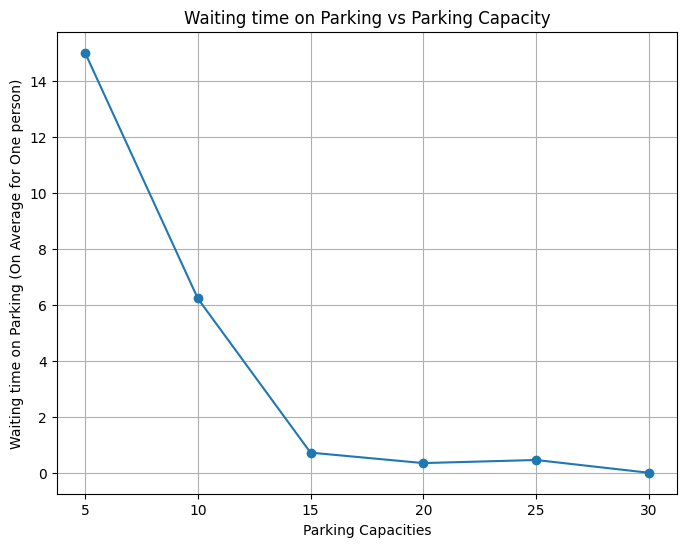

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(capacities, avg_waiting_time_parking, marker='o')
plt.xlabel("Parking Capacities")
plt.ylabel("Waiting time on Parking (On Average for One person)")
plt.title("Waiting time on Parking vs Parking Capacity")
plt.grid(True)
plt.show()

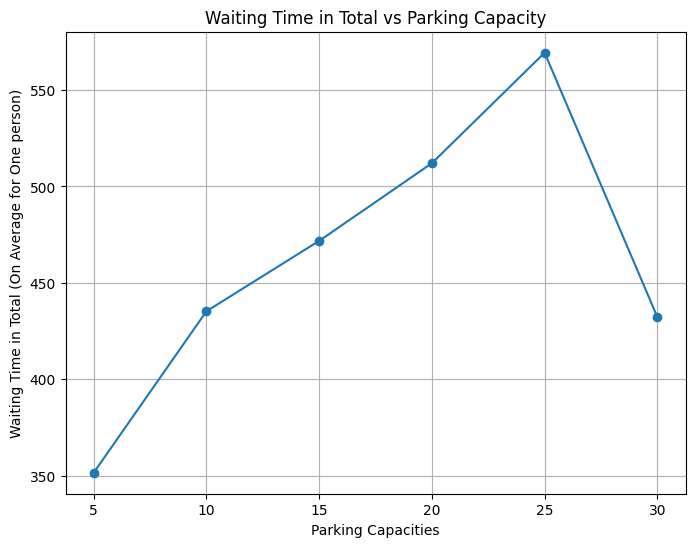

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(capacities, avg_wait_all_stations, marker='o')
plt.xlabel("Parking Capacities")
plt.ylabel("Waiting Time in Total (On Average for One person)")
plt.title("Waiting Time in Total vs Parking Capacity")
plt.grid(True)
plt.show()

In [ ]:
# AverageWaitingTime=[]
# for station in StationsNameList:
#     AverageWaitingTime+= [np.mean(df_StationWaitingTime.iloc[station,0])]
# AverageWaitingTime

In [ ]:
df_ParkingWaitingTime

NameError: name 'df_ParkingWaitingTime' is not defined

In [ ]:
len(df_StationWaitingTime.iloc[1,0]) == len(df_StationWaitingTime.iloc[2,0])
df_StationWaitingTime

In [ ]:
df_StationServers

In [ ]:
df_StationLineLength_History.iloc[-20:,-40:]

In [ ]:
df_StationLineLength_History.iloc[:,:].T.plot()

In [ ]:
df_cars[-20:]

In [ ]:
TotalFreeAvailableSpotInStations

In [ ]:
[person_history]

In [ ]:
df_StationLines = pd.DataFrame(data, index=StationsNameList, columns=["CurrentLine"])
df_StationLines.index.name="StationNumber"

df_StationLines.iloc[1, 0]=[np.zeros([2,N+1])]+ df_StationLines.iloc[1, 0]
df_StationLines
person_history

In [ ]:
def simulate_adjusted(capacity):
  N = 4 # number of stations
  CarArrivalRatePerUnitTime = 110/(3*60*60) # number of arrivals per iteration (# cars arriving per second)
  df_ParkingWaitingTime = pd.DataFrame(data=np.zeros(1), columns=["WaitingTime"])
  df_cars = pd.DataFrame(data=np.zeros(1), columns=["#NotProcessedPeopleInCar"])
  ProcessRate = 100 # max number of people can enter to stations line in each second
  MaxLength = 100
  ParkingCapacity = capacity

  # parkingcapacities = list(range(5, 66, 5))
  Cars_in_ParkingLine = []
  NumberOfCarsInParkingLine = 0
  EntranceLine_list = []
  ExitLine_list = []
  EntranceLineLength_list = [0]
  OccupiedParking_list = [0]
  ParkingWaitingLineLength_list = [0]
  FullyProcessedPeople = np.zeros(N+1)

  # data = [[[],]*N]
  data =[[[],]*1]


  StationsNameList = [(i) for i in range(N)]
  df_StationLines = pd.DataFrame(data, index=StationsNameList, columns=["CurrentLine"])
  df_StationLines.index.name = "StationNumber"

  df_StationWaitingTime = pd.DataFrame(data, index=StationsNameList, columns=["WaitingTime"])
  df_StationWaitingTime.index.name = "StationNumber"

  df_StationLineLength = pd.DataFrame(0, index=StationsNameList, columns=["LineLength"])
  df_StationLineLength.index.name = "StationNumber"

  df_StationServers = pd.DataFrame(np.array([7,3,3,3]).astype(int), index=StationsNameList, columns=["NumberOfServers"])
  df_StationServers.index.name="StationNumber"

  df_StationLineLength_History = df_StationLineLength.copy()
  df_StationLineLength_History.columns = ["0"]

  Init_state =  np.zeros(N)
  Init_state =  np.ones([N]) #random_Transition_matrix(N)[0,:]
  new_state_prob = Init_state
  Transition_matrix = np.ones([N,N])/N # random_Transition_matrix(N)
  distributions = [
          #('normal', {'loc': 20, 'scale': 10}),  # Normal distribution for first station
          #('normal', {'loc': 20, 'scale': 10}),  # Normal distribution for second station
          #('normal', {'loc': 20, 'scale': 10}),  # Normal distribution for third station
          #('uniform', {'low': 10, 'high': 100}),  # Uniform distribution for fourth station
          #('exponential', {'scale': 20}),  # Exponential distribution for fifth station
          #('uniform', {'low': 400, 'high': 800}),  # Uniform distribution for 1st station,
          #('uniform', {'low': 200, 'high': 400}),  # Uniform distribution for 2nd station
          #('uniform', {'low': 200, 'high': 400}),  # Uniform distribution for 3rd station
          #('uniform', {'low': 200, 'high': 400}),  # Uniform distribution for 4th station
          ('exponential', {'scale': 600}),  # Uniform distribution for 1st station, clothing
          ('exponential', {'scale': 300}),  # Uniform distribution for 2nd station
          ('exponential', {'scale': 300}),  # Uniform distribution for 3rd station
          ('exponential', {'scale': 300}),  # Uniform distribution for 4th station
      ]
  #generating service time

  ParkingID = 0
  CarID = 0
  for CurrentTime in range(int(3.5*60*60)): # Studied period of time
  ########################################################################
  ########        Process How Cars Enter the Parking         #############
  ########################################################################
    if (CurrentTime<3*60*60):#3*60*60 # if Active hours
      # New cars arrived and add them to the parking waiting line
      CurrentCarArrivalRate = np.random.poisson(CarArrivalRatePerUnitTime, 1)[0] # number of car arrival rate

      # create counter for new car arrived
      for NewCar in range(CurrentCarArrivalRate):
        df_ParkingWaitingTime.loc[ParkingID, "WaitingTime"] = 0
        Cars_in_ParkingLine.append(ParkingID)
        ParkingID += 1


      # When there are available spots, allow cars in parking waiting line to enter
      NumberOfCarsinParkingLot = sum(df_cars.loc[:,"#NotProcessedPeopleInCar"]>0) # Calculate number of cars in the parking lot, say k
      ParkingAvailbaleCapacity = int(ParkingCapacity - NumberOfCarsinParkingLot)
      NewCarsEnteringTheParking = Cars_in_ParkingLine[0:ParkingAvailbaleCapacity] # First k cars in the parking waiting line can now park their cars
      Cars_in_ParkingLine = Cars_in_ParkingLine[ParkingAvailbaleCapacity:]        # The other cars still in parking waiting line

      for WaitingParkingID in Cars_in_ParkingLine:
        df_ParkingWaitingTime.loc[WaitingParkingID,"WaitingTime"] += 1

      NumberOfNewCarsEnteringTheParking = len(NewCarsEnteringTheParking)
      NumberOfCarsInParkingLine = len(Cars_in_ParkingLine)

      # FullyProcessedPeople[0]=FullyProcessedPeople[0]+(CurrentCarArrivalRate-CurrentFeasibleCarArrivalRate) # it's not actually exactly fully processed,
                                                                                                # but all who left beceause they had no available choice at their last step
                                                                                                # [0] counts number of cars that left due to parking capacity constraints

      for NewCar in range(NumberOfNewCarsEnteringTheParking):
          NumberOfPeopleInCar=np.random.randint(1,3)
          df_cars.loc[CarID,"#NotProcessedPeopleInCar"] = NumberOfPeopleInCar
          for i in range(NumberOfPeopleInCar):
            NewCarPeople = np.zeros([2,N+1])
            NewCarPeople[1,-1] = CarID
            NewCarPeople[0,-1] = 4*60 # assume each person spends 4 min. at parking
            NewCarPeople[0,:-1] = Transition_time(distributions, N)
            # we randomly generate the amount of time each person spends in each station server
            # time spent at each station is btw. 30 <= t <= 240 secs

            if (np.random.rand()>0.25): NewCarPeople[0,0]=0 # only %25 of shoppers complete clothing (assume station 0 is for clothing)
            EntranceLine_list = [NewCarPeople] + EntranceLine_list
            # entranceline_list is a list of arrays, where each array contains the data of the time a single person spends at each station
          CarID+=1
        # print(NewCarPeople)

          # EntranceLine_list=[np.zeros([N])]*CurrentArrivalRate+EntranceLine_list # modify it that some of them will leave ...
    else: EntranceLine_list = EntranceLine_list # modify it that some of them will leave ...

  ########################################################################
  ########      Process how people enter the stations' lines   ############
  ########################################################################
      # How many free spots are available in all stations, so we can atmost let that number in
    TotalFreeAvailableSpotInStations = MaxLength*N-df_StationLineLength.iloc[:, 0].sum()

    if(TotalFreeAvailableSpotInStations>0):
        ProcessNowRate = min(ProcessRate, len(EntranceLine_list), TotalFreeAvailableSpotInStations) # number of people enter to the end of stations' lines
        for _ in range(ProcessNowRate):
          person_history = EntranceLine_list[-1].copy()
          del EntranceLine_list[-1]# remove this person from list of people in the entarnce line

          Adjusted_Init_state = np.zeros(N)
          FreeStationIndex = list(np.argwhere(df_StationLineLength<MaxLength)[:,0]) # find index of free stations
          FullStationIndex = list(np.argwhere(df_StationLineLength>=MaxLength)[:,0]) # find index of full stations
          FeasibleStationIndex = list (set(FreeStationIndex).intersection(set(list(np.argwhere(person_history[0,:-1]>0)[:,0]))))
          # feasible station: A station where the person's transition matrix indicates they spend >= 0 time at that station
          InFeasibleStationIndex = list (set(FullStationIndex).union(set(list(np.argwhere(person_history[0,:-1]==0)[:,0]))))

          if(len(FeasibleStationIndex)>0):
            # EmptyStationIndex = list((df_StationLineLength < 20).values)
            Adjusted_Init_state[FeasibleStationIndex] = (0.001+Init_state[FeasibleStationIndex])/(Init_state[FeasibleStationIndex].sum()+0.001*len(FeasibleStationIndex))
            #Normalizes the probabilities by dividing each by the total sum of feasible station probabilities. The small value (0.001) is also added to the denominator to prevent division by zero.
            #Result: This line adjusts the initial state probabilities (Init_state) for stations that are feasible, ensuring that the probabilities sum to 1
            Adjusted_Init_state[InFeasibleStationIndex] = 0
            #Set the probability to zero for infeasible stations

            station = np.random.choice(StationsNameList, size=1, p=list(Adjusted_Init_state))[0]
            # randomly chooses one value from StationsNameList given the adjusted probabilities

            # person_history[0,station]+=1
            #add the person to the chosen station's line & update the length of the line
            df_StationLines.iloc[station, 0] = [person_history] + df_StationLines.iloc[station, 0]
            df_StationLineLength.iloc[station, 0]=len(df_StationLines.iloc[station, 0]) #df_StationLineLength.iloc[station, 0]+1

    for station in StationsNameList: df_StationLineLength.iloc[station, 0]=len(df_StationLines.iloc[station, 0])
  ########################################################################
  ########      Process how they transit and exit stations' lines   ############
  ########################################################################
    new_state_prob = np.dot(new_state_prob, Transition_matrix)
    NonEmptyStationIndex = list(np.argwhere(df_StationLineLength>0)[:,0])
      #finds stations that have people in line

      # print("777777", df_StationLineLength, NonEmptyStationIndex)
      # print('***', list(df_StationLineLength.iloc[NonEmptyStationIndex].index))

    for station in NonEmptyStationIndex: #list(df_StationLineLength.iloc[NonEmptyStationIndex].index):
      PeopleInStationLineOutOfServer = (df_StationLineLength.iloc[station, 0]-min(df_StationLineLength.iloc[station, 0], df_StationServers.iloc[station, 0]))
      # number of people not being served
      for k in range(PeopleInStationLineOutOfServer):
        #updating the time a person has spent waiting in line to be served (+ 1 sec)
        df_StationLines.iloc[station, 0][k][1,station]+=1 # add how many seconds this person is staying in this station's line
      # people currently being served
      PeopleInStationServer = min(df_StationLineLength.iloc[station, 0], df_StationServers.iloc[station, 0])
      ServedPeople=0
        #initializing a counter for the # of people who have been FULLY served
      for k in range(PeopleInStationServer): # go through people who are currently being served

        # print(StaionBusyServer, k)

        # print(df_StationLines.loc[station, ["CurrentLine"]])
        #increment time the person has spent waiting to be served/being served
        #and decrement their remaining time to be served at the station
        df_StationLines.iloc[station, 0][-k+ServedPeople-1][1,station]+=1 # add to see how many seconds this person is staying in this station's line
        df_StationLines.iloc[station, 0][-k+ServedPeople-1][0,station]-=1 # deduct to see how many seconds this person left to be served by this station's server
        if(df_StationLines.iloc[station, 0][-k+ServedPeople-1][0,station]==0): #if service is complete (wait time == 0)
          #collecting their data and recording how long the person waited, then remove them from the station line
          person_history = df_StationLines.iloc[station, 0][-k+ServedPeople-1].copy()
          df_StationWaitingTime.iloc[station, 0]= [person_history[1,station]] + df_StationWaitingTime.iloc[station, 0] # records how long the person waited at this station
          del df_StationLines.iloc[station, 0][-k+ServedPeople-1] # removes the person from the station's line
          #increment the count of served people
          ServedPeople +=1
          #update line length
          df_StationLineLength.iloc[station, 0]=len(df_StationLines.iloc[station, 0]) #df_StationLineLength.iloc[station, 0]-1

    # Now the first person in this line person goes to another station if she hasn't been to at least one
      # finds stations with open space that the person hasn't visited
          OpenStationIndex = list (set(list(np.argwhere(df_StationLineLength<MaxLength)[:,0])).intersection(set(list(np.argwhere(person_history[0,:-1]>0)[:,0]))))
          # print("888888   ", OpenStationIndex, station)
          if(len(OpenStationIndex)>0): # check if there are open stations
              Current_state_prob = Transition_matrix[station, :].copy() #np.zeros(N) # list(set(x) - set(y))
              # OpenStationIndex = list (set(list(np.argwhere(df_StationLineLength<MaxLength)[:,0])).intersection(set(list(np.argwhere(person_history>0)[:,0]))))
              BlockedStationIndex = list (set(list(np.argwhere(df_StationLineLength>=MaxLength)[:,0])).union(set(list(np.argwhere(person_history[0,:-1]==0)[:,0]))))
              #finds stations that are blocked (either full or previously visited)
              Current_state_prob[:]=(0.001+Current_state_prob[:])/(np.sum(Current_state_prob[:])+0.001*N)
              #normalizes the current state probabilities:
              # adds a small value to each to avoid a probability of 0 and makes all probabilities sum to 1


              Adjusted_current_state_prob=np.zeros(N)
              Adjusted_current_state_prob[OpenStationIndex] = Current_state_prob[OpenStationIndex]/Current_state_prob[OpenStationIndex].sum()
              #adjusting the state probabilities for open stations
              Adjusted_current_state_prob[BlockedStationIndex]=0
              #if blocked, the new adjusted state probability is set to 0
              new_station = np.random.choice(StationsNameList, size=1, p=list(Adjusted_current_state_prob))[0]
              #randomly selects a new stations based on the adjusted probabilities
              # print("\n **********   ",x,  new_station,(person_history), Adjusted_current_state_prob)
              df_StationLines.iloc[new_station, 0] = [person_history] + df_StationLines.iloc[new_station, 0]
              #move person to newly selected station
              df_StationLineLength.iloc[new_station, 0] = len(df_StationLines.iloc[new_station, 0]) #df_StationLineLength.iloc[new_station, 0]+1
              #update line length


          else: #if there are no more available stations, the person exits the code and is added to the exit list
            # print(person_history)
            ExitLine_list = [person_history] + ExitLine_list
            FullyProcessedPeople[int(sum(person_history[1,:-1]>0))] = FullyProcessedPeople[int(sum(person_history[1,:-1]>0))]+1
            # it's not actually exactly fully processed, but all who left beceause they had no available choice at their last step
            # PersonCarID=person_history[1,-1]

  ########################################################################
  ########        simulate waiting time for people to get to the car         ############
  ########################################################################

    ServedPeople_=0
    CurrentExitLine_length=len(ExitLine_list)
    for kkk in range(CurrentExitLine_length):
      ExitLine_list[ServedPeople_-kkk-1][0,-1]=ExitLine_list[ServedPeople_-kkk-1][0,-1]-1
      # print(ExitLine_list[ServedPeople_-kkk-1])
      if(ExitLine_list[ServedPeople_-kkk-1][0,-1]==0):
        PersonCarID=ExitLine_list[ServedPeople_-kkk-1][1,-1]
        # print(PersonCarID, "***", ExitLine_list[ServedPeople_-kkk-1], "\n\n")
        del ExitLine_list[ServedPeople_-kkk-1]
        ServedPeople_+=1
        df_cars.loc[PersonCarID,"#NotProcessedPeopleInCar"] = df_cars.loc[PersonCarID,"#NotProcessedPeopleInCar"]-1
        # state=np.dot(state,P)
        # print(state)
        # stateHist=np.append(stateHist,state,axis=0)
        # dfDistrHist = pd.DataFrame(stateHist)
        # dfDistrHist.plot()
        # plt.show()

    # print(df_StationLineLength)

    df_StationLineLength.columns=[str(CurrentTime+1)]
    df_StationLineLength_History=pd.concat([df_StationLineLength_History, df_StationLineLength], axis=1)
    EntranceLineLength_list=EntranceLineLength_list+[len(EntranceLine_list)]
    OccupiedParking_list=OccupiedParking_list+[sum(df_cars.loc[:,"#NotProcessedPeopleInCar"]>0)]
    ParkingWaitingLineLength_list=ParkingWaitingLineLength_list + [NumberOfCarsInParkingLine]

  AverageWaitingTime=[]
  for station in StationsNameList:
    AverageWaitingTime+= [np.mean(df_StationWaitingTime.iloc[station,0])]
  avg_wait_all_stations = sum(AverageWaitingTime) / len(AverageWaitingTime)
  avg_wait_whole_pantry = (sum(AverageWaitingTime) + 240 + df_ParkingWaitingTime.iloc[:,0].mean()) / (len(AverageWaitingTime) + 1 + 1) # includes parking


  return df_StationLineLength_History, EntranceLineLength_list, OccupiedParking_list, ParkingWaitingLineLength_list, FullyProcessedPeople, avg_wait_all_stations, avg_wait_whole_pantry, df_StationWaitingTime, df_ParkingWaitingTime

In [ ]:
df_StationLineLength_History, EntranceLineLength_list, OccupiedParking_list, ParkingWaitingLineLength_list, FullyProcessedPeople, avg_wait_all_stations, avg_wait_whole_pantry, df_StationWaitingTime, df_ParkingWaitingTime = simulate_adjusted(10)

In [ ]:
# df_ParkingWaitingTime
# df_ParkingWaitingTime.iloc[:,0].mean() # Average Waiting Time in Seconds
# # avg_wait_all_stations
# df_ParkingWaitingTime.iloc[:,0]
# df_ParkingWaitingTime.iloc[:,0].mean()
avg_wait_whole_pantry

In [ ]:
def simulate_parking_adjusted():
  numsimulations = 5
  average_occupied_capacity = []
  average_waiting_time = []
  average_all_stations = []
  average_whole_pantry = []
  for capacity in range(5,31,5):
    occupied_i = []
    parkingwaiting_i = []
    all_stations_i = []
    whole_pantry_i = []
    for i in range(numsimulations):
      df_StationLineLength_History, EntranceLineLength_list, OccupiedParking_list, ParkingWaitingLineLength_list, FullyProcessedPeople, avg_wait_all_stations, avg_wait_whole_pantry, df_StationWaitingTime, df_ParkingWaitingTime = simulate_adjusted(capacity)
      avg_occupied = sum(OccupiedParking_list) / len(OccupiedParking_list)
      avg_parkingwaiting = df_ParkingWaitingTime.iloc[:,0].mean()
      whole_pantry_i.append(avg_wait_whole_pantry)
      occupied_i.append(avg_occupied)
      parkingwaiting_i.append(avg_parkingwaiting)
      all_stations_i.append(avg_wait_all_stations)

    average_occupied_capacity.append(sum(occupied_i) / len(occupied_i))
    average_waiting_time.append((sum(parkingwaiting_i) / len(parkingwaiting_i)) / 60) # to get from seconds to minute waiting time
    average_all_stations.append((sum(all_stations_i) / len(all_stations_i)) / 60) # to get from seconds to minute waiting time

    print(whole_pantry_i)
    average_whole_pantry.append((sum(whole_pantry_i) / len(whole_pantry_i)) / 60) # to get from seconds to minute waiting time

    print("average_occupied_capacity_parking: " + str(average_occupied_capacity))
    print("average_waiting_time_parking: " + str(average_waiting_time))
    print("average_wait_time_stations: " + str(average_all_stations))
    print("average_wait_time_pantry: " + str(average_whole_pantry))

  return average_occupied_capacity, average_waiting_time, average_all_stations, average_whole_pantry

In [ ]:
avg_occupied_capacity_parking, avg_waiting_time_parking, avg_wait_all_stations, avg_whole_pantry = simulate_parking_adjusted() # ~takes 30 minutes

In [ ]:
import matplotlib.pyplot as plt

capacities = list(range(5, 31, 5))

plt.figure(figsize=(8, 6))

plt.plot(capacities, avg_waiting_time_parking, marker='o', label="Avg Waiting Time (Parking)")
plt.plot(capacities, avg_wait_all_stations, marker='o', label="Avg Waiting Time (Stations)")
plt.plot(capacities, avg_whole_pantry, marker='o', label="Avg Waiting Time (Stations + Parking)")

plt.xlabel("Parking Capacities")
plt.ylabel("Time in Minutes")
plt.title("Parking Capacity effect on Pantry Times")
plt.grid(True)

plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

capacities = range(5, 55, 5)  # parking capacities from 5 to 50, step by 5
average_fully_served_people = []

for capacity in capacities:
    # get the data for the given capacity
    df_StationLineLength_History, EntranceLineLength_list, OccupiedParking_list, ParkingWaitingLineLength_list, FullyProcessedPeople, avg_wait_all_stations, df_StationWaitingTime, df_ParkingWaitingTime = simulate_adjusted(capacity)

    # Calculate the average number of fully served people across stations for this capacity
    avg_fully_served = np.mean(FullyProcessedPeople)
    average_fully_served_people.append(avg_fully_served)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(capacities, average_fully_served_people, marker='o', label="Avg #Full Served People")
plt.title("Average fully served people throughout a 3-hour day")
plt.xlabel("#Parking Capacity")
plt.ylabel("#People")
plt.legend()
plt.text(30, min(average_fully_served_people) + 10, "Longer queues so fewer people served!",
         bbox=dict(facecolor="lightblue", alpha=0.5))
plt.show()